# Data analysis 

According to the problem instructions, these are the variables on the datasets: 

**train.csv & test.csv:**  

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee 20usd fee assigned to responsible judgments
    state_fee - 10usd fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations

**train.csv only:**

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant
___

## **Preliminary selection of variables**: 
Based on their description, the following variables seem a reasonable starting choice of features to consider: 
- "violation_street_name",
- "ticket_issued_date",
- "hearing_date",
- "disposition",
- "fine_amount",
- "discount_amount",
- "judgment_amount", 
- "compliance" (target)

The names of agency and inspector issuing the ticket, as well as the name and mailing address of the violator, are left out. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 

Let's drop missing values, find the number of non-compliant tickets, and check the distributions of the numerical variables:

In [2]:
df1= df[ ["violation_street_name","ticket_issued_date","hearing_date","disposition",
          "fine_amount","discount_amount", "judgment_amount", "compliance"]].copy()
df1["compliance"].astype("category",inplace=True)

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
print("after droping Nan values: {}".format(len(df1)))
#df1.describe()

initial number of tickets: 250306
after droping Nan values: 159653


<IPython.core.display.Javascript object>


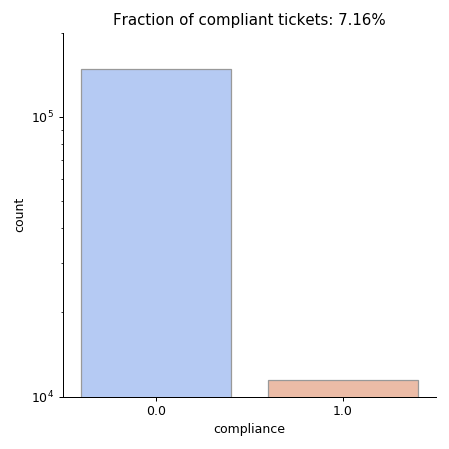

In [3]:
sns.catplot(x="compliance", kind="count", edgecolor=".6", data=df1,palette='coolwarm')
plt.gca().set_title("Fraction of compliant tickets: {:0.2f}%".format( 100*sum(df1.compliance)/len(df1) ))
plt.gca().set_yscale('log')
plt.gca().set_ylim([1e4,2e5])
plt.tight_layout()

## Fine amounts and discounts:

It is reasonable to guess that a discount on a fine may pursue someone to pay it. Lets check the distribution of discount value for *compliants* and *non-compliants*:

<IPython.core.display.Javascript object>


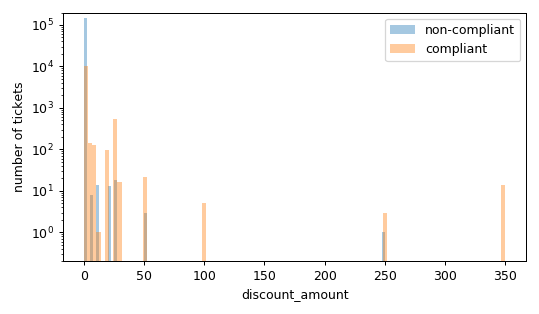

In [4]:
fig1= plt.figure(figsize=(6,3.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
        data = df1[df1["compliance"]==i]
        sns.distplot(data["discount_amount"],label=j,hist=True,norm_hist=False,kde=False,bins=100)
plt.gca().set_yscale("log")
plt.gca().set_ylim([2e-1,2e5])
plt.gca().set_ylabel("number of tickets")
plt.legend()
plt.tight_layout()

In [5]:
av_discount_non_comp = df1.where( df1["compliance"]==0.0)["discount_amount"].agg(np.mean)
av_discount_comp     = df1.where( df1["compliance"]==1.0)["discount_amount"].agg(np.mean)
print("averages discount compliant tickets: {:0.3f}".format(av_discount_comp))
print("averages discount non-compliant tickets: {:0.3f}".format(av_discount_non_comp))

averages discount compliant tickets: 2.224
averages discount non-compliant tickets: 0.009


Though the averages discounts are rather similar, the discount distribution is rather different. From the histograms it can be seen that almost all the non-compliant tickets have no discount, and a *tail* of tickets with no-null discounts is present for the compliants distribution. Let's see the *fine* and *judgement amounts* distributions depending on the compliance status:

<IPython.core.display.Javascript object>


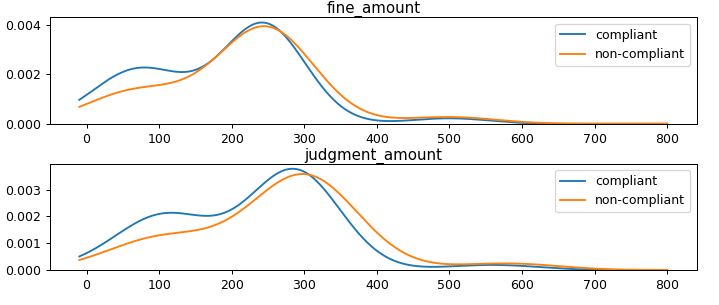

In [6]:
fig2, _ = plt.subplots(2,1,figsize=(8,1.7*2)) 
plt.tight_layout()
for i,var in enumerate(["fine_amount","judgment_amount"]):
    axi=plt.subplot(2,1,i+1)
    for i,j in [(1,"compliant"),(0,"non-compliant")]:
        data = df1[df1["compliance"]==i]
        sns.kdeplot(data[var],label=j,gridsize=2500,clip=(-10,800))
        axi.set_title(var,pad=.15)

Remind that both variables are related, the fine amount is the sum of different values (judgement_amount, additional fees, discount). For both amount types, the normalized distributions of compliants and non-compliants differ, the former having a two-peak structure and the latter a one-peak shape with larger tails. 

## Waiting time between hearing and ticket issuing:
One may think that the time interval between the hearing date and the ticket issuing date has an influence on wheter a ticket is compliant or not:

<IPython.core.display.Javascript object>


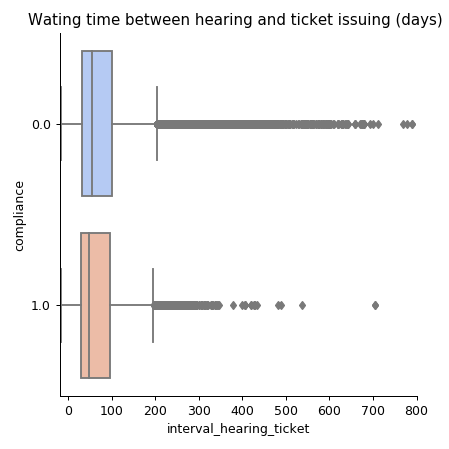

In [7]:
# time interval between hearing and ticket issued date
df1["ticket_issued_date"] = pd.to_datetime(df1["ticket_issued_date"]) #df1["ticket_issued_date"].astype("datetime64[D]")
df1["hearing_date"]=pd.to_datetime(df1["hearing_date"])

df1["interval_hearing_ticket"] = df1.hearing_date - df1.ticket_issued_date
df1["interval_hearing_ticket"] = df1["interval_hearing_ticket"].apply(lambda x: x.days)
sns.catplot(x='interval_hearing_ticket',y='compliance', kind="box",data=df1,orient="horizontal",palette="coolwarm")
plt.gca().set_xlim([-20,800])
plt.gca().set_title("Wating time between hearing and ticket issuing (days) ")
plt.tight_layout()

It can be seen that:     
- For waiting periods >= than ~200 days there are many more non-compliant than compliant cases 
- The quartiles for both distributions are somehow similar distributed but the means differ, being the mean for  compliant tickets smaller.  
- It makes no sense to have a hearing date before the ticket_issued_date, but both distributions present such values so probably it's an error on the data. Let's see how many of these cases are:

In [8]:
print("tickets where hearing date is before ticket_issued date: {}".format( len(df1[ df1.interval_hearing_ticket<0])))
df1.drop(df1[ df1.interval_hearing_ticket<0].index, inplace=True)

tickets where hearing date is before ticket_issued date: 80


<IPython.core.display.Javascript object>


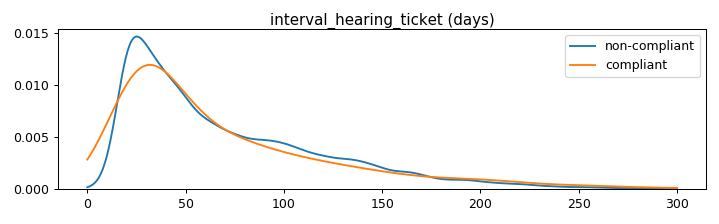

In [9]:
fig4 = plt.figure(figsize=(8,2.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
    data = df1[df1["compliance"]==i]
    sns.kdeplot(data["interval_hearing_ticket"],label=j,gridsize=1500,clip=(0,300))
    plt.gca().set_title("interval_hearing_ticket (days)",pad=.15)
fig4.tight_layout()

## Disposition categories

In [10]:
encoding_list = list( enumerate(df1["disposition"].unique()) )
df1["disposition"] = df1["disposition"].apply(  lambda x: [y[0] for y in encoding_list if y[1]==x][0]  )

<IPython.core.display.Javascript object>


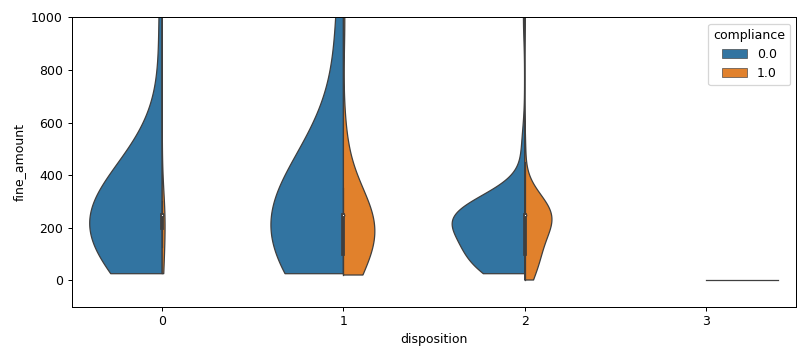

*** disposition values ***
(0, 'Responsible by Default')
(1, 'Responsible by Determination')
(2, 'Responsible by Admission')
(3, 'Responsible (Fine Waived) by Deter')


In [11]:
plt.figure(figsize=(9,4))
ax = sns.violinplot(x="disposition", y="fine_amount", hue="compliance", data=df1,split=True,
                    scale="count",bw=.3,cut=0,gridsize=2500,linewidth=1.0)
ax.set_ylim([-100,1000])
plt.tight_layout()
print("*** disposition values ***")
for i in encoding_list:
    print(i)
plt.tight_layout()

The plot above displays the *fine_amount* distributions for different disposition categories and different compliance status. Clearly, for disposition values 1 and 2 the number of compliant tickets is much larger in comparision to compliance values 0 and 3. 

## Geographical distribution

It is perhaps the most obvious guess that the compliance of a fine ticket dependens on the place/street where the violiation takes place, as the ubication in a city tends to reflect things like the economic wealth of the inhabitants. 
In order to visualize the location of the tickets,  the `addresses.csv` and `latlons.csv` files must be first joined (`DataFrame.join`). The resulting dataframe is joined then with the dataframe with the ticket compliance info:

In [12]:
dfa = pd.read_csv("addresses.csv")
dfa.dropna(inplace=True)
#print(len(dfa))

street_parser = lambda x: " ".join( x.split(",")[0].split(" ")[1:]).strip()
address_parser = lambda x: x.split(",")[0].strip()
dfa["street"] = dfa["address"].apply(street_parser)
dfa["address"] = dfa["address"].apply(address_parser)
dfa["zip_code"] = dfa["address"].str.findall('\d+').apply( lambda x: x[0])
dfa.head(3)

,ticket_id,address,street,zip_code
0,22056,2900 tyler,tyler,2900
1,27586,4311 central,central,4311
2,22062,1449 longfellow,longfellow,1449


In [13]:
dflalo = pd.read_csv("latlons.csv")
dflalo.dropna(inplace=True)
dflalo["street"]   = dflalo["address"].apply(street_parser)
dflalo["address"]  = dflalo["address"].apply(address_parser)
dflalo["zip_code"] = dflalo["address"].str.findall('\d+').apply( lambda x: x[0])
print(len(dflalo) )
dflalo.head(3)

121762


,address,lat,lon,street,zip_code
0,4300 rosa parks blvd,42.346169,-83.079962,rosa parks blvd,4300
1,14512 sussex,42.394657,-83.194265,sussex,14512
2,3456 garland,42.373779,-82.986228,garland,3456


In [14]:
print(  "Number of different street names in adresses csv: {}".format(len(dfa.street.unique())) )
print(  "Number of different street names in latlon  csv: {}".format(len(dflalo.street.unique())) )
print(  "Number of different street names in train data set: {}".format(len(df1.violation_street_name.unique())) )

Number of different street names in adresses csv: 1831
Number of different street names in latlon  csv: 1830
Number of different street names in train data set: 1716


In [15]:
df_geoloc = dfa.set_index("address").join(dflalo.set_index("address"),how="left",lsuffix='_caller', rsuffix='_other')
df_geoloc.dropna(inplace=True)
df_geoloc.reset_index(inplace=True)
df_geoloc.set_index("ticket_id",inplace=True)
df_joined = df1.join(df_geoloc,how="left")

#print(len(df_joined.violation_street_name.unique()))
#df_joined[["violation_street_name","address"]].head(5)

<IPython.core.display.Javascript object>


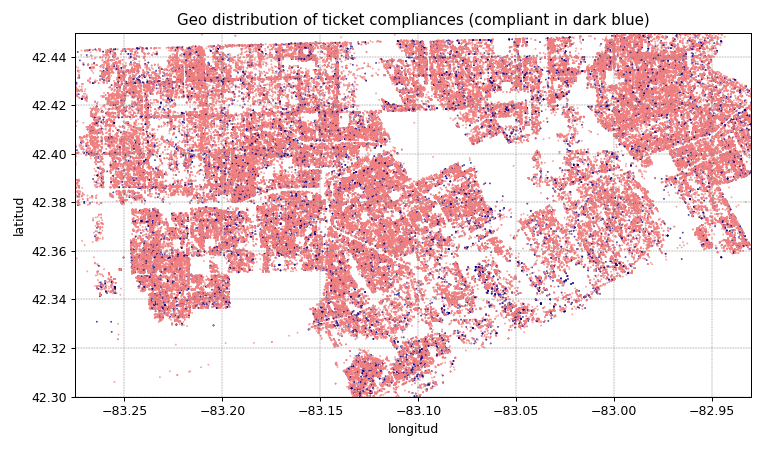

In [18]:
geo_fig = plt.figure(figsize=(8.5,5))
color_code = {0.0:"lightcoral",1.0:"darkblue"}
col = [color_code[i] for i in df_joined["compliance"]]
ax = plt.scatter(df_joined['lon'],df_joined['lat'],c=col,s=0.15,label=col)
ax = plt.gca()
ax.set_xlabel("longitud")
ax.set_ylabel("latitud")
ax.set_title("Geo distribution of ticket compliances (compliant in dark blue)")
ax.grid(True,color='grey', linestyle='--', linewidth=.4)
plt.gca().set_xlim([-83.275,-82.93])
plt.gca().set_ylim([42.3,42.45])
plt.tight_layout()

<IPython.core.display.Javascript object>


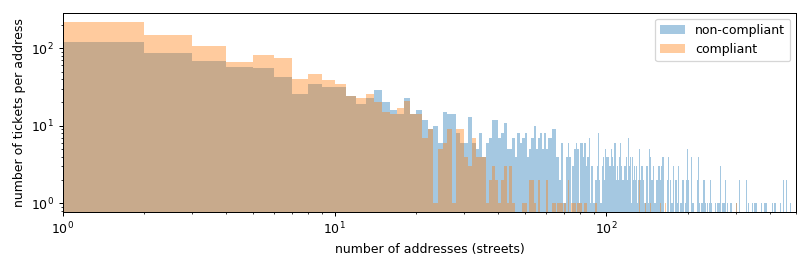

In [17]:
groups_df = df_joined.groupby(["compliance","violation_street_name"]).groups
compliant_tickets_per_address = [ len(groups_df[g]) for g in groups_df if g[0]==1]
non_compliant_tickets_per_address = [ len(groups_df[g]) for g in groups_df if g[0]==0]

plt.figure(figsize=(9,3))
sns.distplot(non_compliant_tickets_per_address,kde=False,label="non-compliant",bins=range(0,1000,1))
sns.distplot(compliant_tickets_per_address,kde=False,label="compliant",bins=range(0,1000,1))
plt.legend()
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_xlabel("number of addresses (streets)")
plt.gca().set_ylabel("number of tickets per address")
plt.gca().set_xlim([1,500])
plt.tight_layout()

It can be seen that non-compliance of tickets (dark blue points) are common along some some streets. That
will be a good feature for the model.